# Renormalization group

Given the quantum Ising Hamiltonian in transverse field on a one-dimensional lattice with nearest neighbor interaction:
$$
\hat{H} = \lambda \sum_{i=1}^{N} \sigma_z^{(i)} + \sum_{i=1}^{N-1} \sigma_x^{(i)} \sigma_x^{(i+1)}
$$

where $ \sigma_x $ and $ \sigma_z $ are the Pauli matrices and $ \lambda $ is the transverse field.

1. Compute the ground state energy as a function of the transverse field $ \lambda $ by means of the real-space RG algorithm.
2. Compute the ground state energy as a function of $ \lambda $ by means of the INFINITE DMRG algorithm.
3. Compare the results between them and with the mean field solution.

In [46]:
# ===========================================================================================================
# IMPORT ZONE
# ===========================================================================================================

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

# ===========================================================================================================
# ISING MODEL
# ===========================================================================================================

def pauli_matrices():
  """
  pauli_matrices:
    Builds the Pauli matrices as sparse matrices.

  Returns
  -------
  s_x, s_y, s_z: tuple of sp.csr_matrix
    Pauli matrices for a 2x2 system in sparse format.
  """
  s_x = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
  s_y = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
  s_z = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
  return s_x, s_y, s_z

# ===========================================================================================================

def ising_hamiltonian(N, l):
  """
  ising_hamiltonian:
    Builds the Ising model Hamiltonian using sparse matrices.

  Parameters
  ----------
  N : int
    Number of spins.
  l : float
    Interaction strength.

  Returns
  -------
  H : sp.csr_matrix
    Sparse Ising Hamiltonian.
  """
  dim = 2 ** N
  H_nonint = sp.csr_matrix((dim, dim), dtype=complex)
  H_int = sp.csr_matrix((dim, dim), dtype=complex)
  
  s_x, _, s_z = pauli_matrices()
  
  for i in range(N):
    zterm = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_z, sp.identity(2**(N - i - 1), format='csr')))
    H_nonint += zterm
    
  for i in range(N - 1):
    xterm = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_x, sp.kron(s_x, sp.identity(2**(N - i - 2), format='csr'))))
    H_int += xterm
  
  H = H_int + l * H_nonint
  return H

# ===========================================================================================================

def projector(H, d_eff):
  _, eigvecs = sp.linalg.eigsh(H, k=d_eff, which='SA')  # Compute the smallest `k` eigenvalues
    
  proj = sp.csr_matrix(eigvecs)

  return proj

# ===========================================================================================================

def initialize_A_B(N):
  s_x, _, _ = pauli_matrices()
  
  A_0 = sp.kron(sp.identity(2**(N - 1), format='csr'), s_x)
  B_0 = sp.kron(s_x, sp.identity(2**(N - 1), format='csr'))
  
  return A_0, B_0

# ===========================================================================================================

def compute_H_2N(N, H, A, B):  
  H_2N = sp.kron(H, sp.identity(2**(N), format='csr')) + sp.kron(sp.identity(2**(N), format='csr'), H) + sp.kron(A, B)
  return H_2N

# ===========================================================================================================

def update_operators(N, H_2N, A, B):
  P = projector(H_2N, d_eff=2**N)
  
  P_dagger = P.conj().T
  I_N = sp.identity(2**N, format='csr')

  # Compute H_Nnn, Ann, Bnn, Pnn
  H_eff = P_dagger @ H_2N @ P
  A_eff = P_dagger @ sp.kron(I_N, A) @ P
  B_eff = P_dagger @ sp.kron(B, I_N) @ P
  
  return H_eff, A_eff, B_eff, P

# ===========================================================================================================
  
def real_space_rg(N, l, threshold, d_eff, max_iter=100):
  prev_energy_density = np.inf
  H = ising_hamiltonian(N, l)
  A, B = initialize_A_B(N)
  curr_dim = N

  for iteration in range(max_iter):
    curr_dim *= 2
    H_2N = compute_H_2N(N, H, A, B)

    # Compute the current energy density and eigenvectors
    E, psi = sp.linalg.eigsh(H_2N, k=d_eff, which='SA')
    E_ground = E[0]
    psi_ground = psi[:, 0]
    
    current_energy_density = E_ground / curr_dim

    # Check for convergence 
    delta = abs(current_energy_density - prev_energy_density)

    if delta > threshold:
      H, A, B, P = update_operators(N, H_2N, A, B)
    else:
      print(f"Convergence achieved at iteration {iteration}")
      break

    # Update previous energy density for next iteration
    prev_energy_density = current_energy_density
    
    if iteration % 10 == 0:
      print(f"Starting iteration {iteration} ...")

  
  print(f"Reached N = 2**{int(np.log2(curr_dim + 1e-12))} = {curr_dim} with precision: delta = {delta}")
  return current_energy_density, E_ground, psi_ground

# ===========================================================================================================

def update_hamiltonian(N, l_values, threshold, max_iter=100):
  # Initialize dictionaries to store eigenvalues and eigenvectors
  gs_density_dict = {}
  gs_energy_dict = {}
  gs_dict = {}
  
  print(f"Analysis with N={2**(max_iter)}...")

  for l in l_values:      
    d_eff = 2**N    
    energy_density_ground, E_ground, psi_ground = real_space_rg(N, l, threshold, d_eff, max_iter)  
    
    gs_density_dict[(2*(max_iter), l)] = energy_density_ground
    gs_energy_dict[(2*(max_iter), l)] = E_ground
    gs_dict[(2**(max_iter), l)] = psi_ground
    
  print("-----------------------------------------")
    
  return gs_density_dict, gs_energy_dict, gs_dict

In [48]:
# Parameters
N = 2
l = 1
threshold = 1e-5
max_iter = 5
d_eff = 2**N

gs_energy_density, gs_energy, gs = real_space_rg(N, l, threshold, d_eff, max_iter)

Starting iteration 0 ...
Reached N = 2**6 = 64 with precision: delta = 0.0002156160560304876


In [49]:
gs_energy_density

-1.2311255207125356

In [50]:
gs_energy

-78.79203332560228

In [8]:
# Parameters
N = 1
l_values = np.linspace(-4, 4, 50)
threshold = 1e-18
max_iter = 50

gs_energy_densities, gs_energies, gs_s = update_hamiltonian(N, l_values, threshold, max_iter)

Analysis with N=1125899906842624...
Starting iteration 0 ...
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Reached N = 2**50 = 1125899906842624 with precision: delta = 2.715051117263556e-08
Starting iteration 0 ...
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Reached N = 2**50 = 1125899906842624 with precision: delta = 7.430269244323995e-08
Starting iteration 0 ...
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Reached N = 2**50 = 1125899906842624 with precision: delta = 1.471618382709039e-08
Starting iteration 0 ...
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting iteration 40 ...
Reached N = 2**50 = 1125899906842624 with precision: delta = 1.2068766430672895e-08
Starting iteration 0 ...
Starting iteration 10 ...
Starting iteration 20 ...
Starting iteration 30 ...
Starting ite

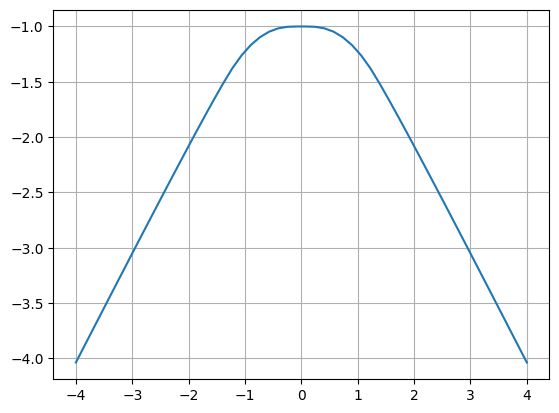

In [9]:
plt.plot(l_values, gs_energy_densities.values())
plt.grid()

In [64]:
gs

array([ 9.44364266e-01-3.28856026e-01j,  1.35923781e-07-6.89069279e-08j,
        9.62758613e-04-3.74112690e-03j, -6.74731115e-09-2.70224355e-09j,
        8.76500430e-04-3.76227274e-03j,  7.73268345e-11-7.79450847e-10j,
       -2.04791454e-05-2.17666213e-05j, -6.31750679e-11+2.25428954e-11j,
       -8.82044501e-08-1.27557444e-07j, -1.66907721e-14-1.63851342e-14j,
       -8.03979405e-10+1.13509862e-11j,  4.06721046e-15-5.56052864e-14j,
        5.75651862e-09+4.43537419e-09j,  1.48368477e-14+1.81047383e-14j,
        5.49610967e-11-3.85128206e-11j, -3.50973046e-14+4.76915194e-14j])

In [115]:
def diagonalize_ising(N_values, l_values, k):
  """
  diagonalize_ising :
    Diagonalize the Ising Hamiltonian for different values of N and l using sparse methods.

  Parameters
  ----------
  N_values : list of int
    Values of N, number of spins in the system.
  l_values : list of float
    Values of l, interaction strength.

  Returns
  -------
  eigenvalues, eigenvectors : tuple of dict
    Eigenvalues and eigenvectors of the Ising Hamiltonian for different
    values of N and l.
  """
  eigenvalues = {}
  eigenvectors = {}
  
  for N in N_values:
    print(f"Diagonalizing Ising Hamiltonian with N={N} ...")
    x = min(k, N - 1)
    
    for l in l_values:
      # Generate the sparse Ising Hamiltonian
      H = ising_hamiltonian(N, l)
      
      # Diagonalize the Hamiltonian
      
      eigval, eigvec = sp.linalg.eigsh(H, k=x, which='SA')  # Compute the smallest `k` eigenvalues
      eigvec = eigvec.T
        
      eigenvalues[(N, l)] = eigval / N
      eigenvectors[(N, l)] = eigvec
  
  return eigenvalues, eigenvectors

exact_gs_energy, exact_gs = diagonalize_ising([8], [l], k=1)

Diagonalizing Ising Hamiltonian with N=8 ...


In [116]:
exact_gs_energy

{(8, 1): array([-1.22974393])}

In [93]:
# Parameters
N_vals = np.arange(1, 2, 1)
l_vals = 0
threshold = 1e-5
max_iter = 200

eigenvalues, eigenvectors = update_hamiltonian(N_vals, l_vals, threshold, max_iter)

TypeError: 'int' object is not iterable

In [9]:
import phase_transition_functions as ptf
import ising_model as im

In [73]:
def plot_eigenvalues(N_values, l_values, eigenvalues):
  # Loop over the values of N (many plots)
  for N in N_values:
    plt.figure(figsize=(8, 5))
      
    # Loop over the first k levels
    energies = []
    for l in l_values:
      energies.append(eigenvalues[(N, l)] / N)

    plt.plot(l_values, energies, label=f'N ={N}')
    
    plt.axvline(x = -1, linestyle="--", color = "red", label="Critical point")
        
    # Plot formatting
    plt.xlabel('Interaction strength (λ)')
    plt.ylabel('Energy')
    plt.title(f'Ground state energy vs λ (N={N})')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

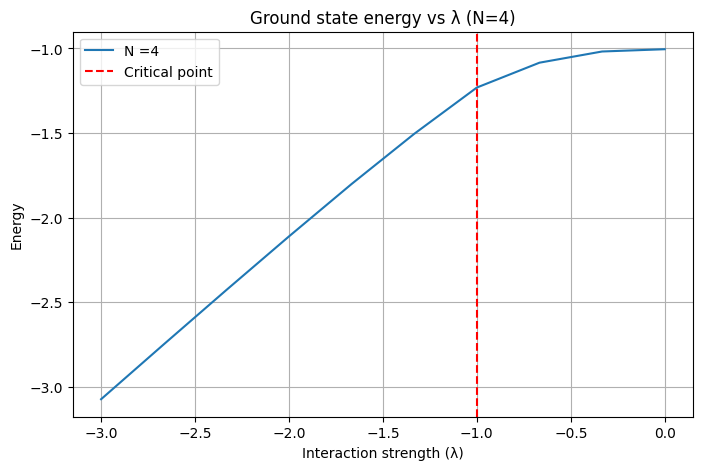

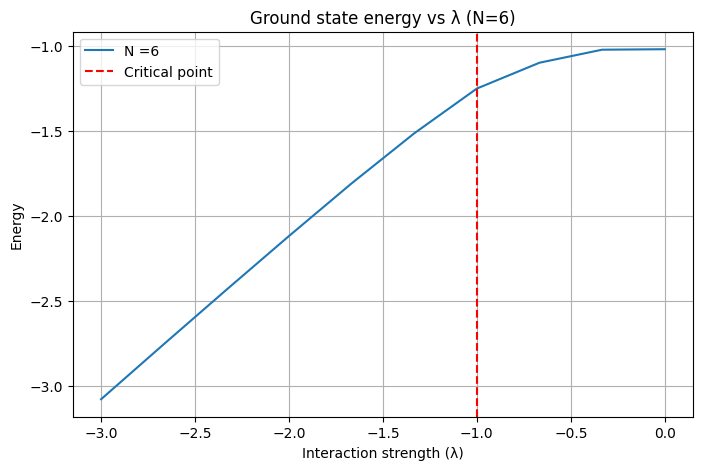

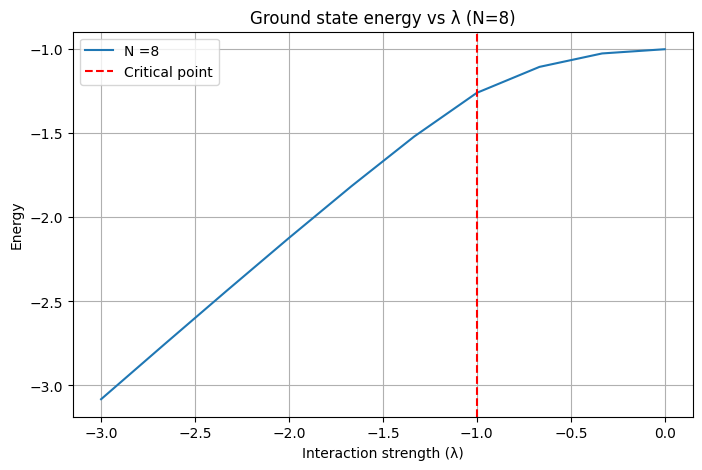

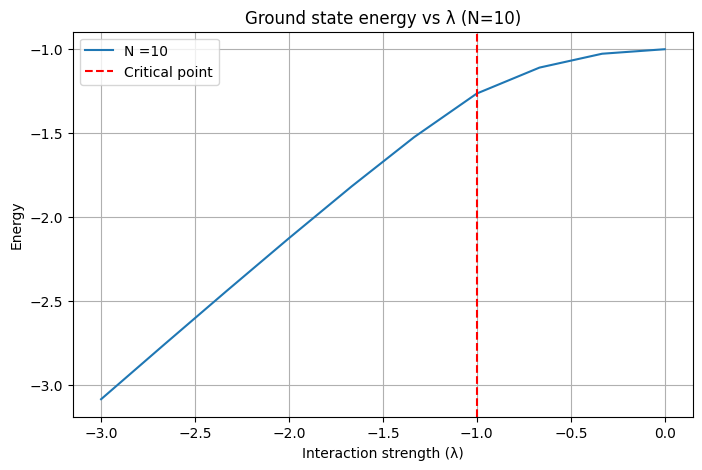

In [28]:
plot_eigenvalues(2*N_vals, l_vals, eigenvalues)

In [90]:
def magnetization(ground_state, N):
  """
  magnetization:
    Computes the magnetization of the ground state vector for an N-spin system.

  Parameters
  ----------
  ground_state : np.ndarray
    Ground state vector of the system.
  N : int
    Number of spins in the system.

  Returns
  -------
  M : float
    Expectation value of the normalized total magnetization operator.
  """
  _, _, s_z = pauli_matrices()  # Retrieve sparse Pauli matrices
  
  M_z = sp.csr_matrix((2**N, 2**N), dtype=complex)
  
  for i in range(N):
    M_z_i = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_z, sp.identity(2**(N - i - 1), format='csr')))
    M_z += M_z_i
    
  M_z /= N
  
  M = ground_state.conj().transpose().dot(M_z.dot(ground_state))
  return M

# ===========================================================================================================

def plot_magnetization(N_values, l_values, eigenvectors):
  """
  plot_magnetization :
    Plot the magnetization as a function of l for different N.
  
  Parameters
  ----------
  N_values : list of int
    Values of N, number of spins in the system.
  l_values : list of float
    Values of l, interaction strength.
  eigenvecttors : np.ndarray
    Precomputed eigenvectors for every (N, l).
  
  Returns
  -------
  None
  """  
  plt.figure(figsize=(8, 5))
    
  # Loop over the values of N (many plots)
  for N in N_values:    
    Ms = []
    # Loop over the first k levels
    for l in l_values:
      M = magnetization(eigenvectors[(N, l)], N)
      Ms.append(M)

    plt.plot(l_values, Ms, marker='^', linestyle='--', label = f"N={N}", markersize=3)
  
  plt.axvline(x=1, linestyle="--", color="red", label="Critical point")
      
  # Plot formatting
  plt.xlabel('Interaction strength (λ)')
  plt.ylabel('Magnetization')
  plt.title(f'Magnetization vs λ')
  #plt.xscale('log')
  plt.legend(loc="lower left")
  plt.grid()
  plt.show()

In [5]:
# Parameters
N_vals = np.arange(3, 4, 1)
l_vals = np.linspace(0.9, 1.3, 20)
threshold = 1e-4
max_iter = 200

eigenvalues, eigenvectors = update_hamiltonian(N_vals, l_vals, threshold, max_iter)

NameError: name 'np' is not defined

In [92]:
plot_magnetization([4], l, eigenvectors)

ValueError: matmul: dimension mismatch with signature (n,k=16),(k=4,1?)->(n,1?)

<Figure size 800x500 with 0 Axes>

**Infinite DMRG**

In [85]:
# ===========================================================================================================

def initialize_operators(m, l):
  """
  initialize_operators _summary_

  Parameters
  ----------
  m : _type_
      _description_
  l : _type_
      _description_

  Returns
  -------
  _type_
      _description_
  """
  s_x, _, s_z = pauli_matrices()
  
  A_L_0 = A_R_0 = sp.identity(2**m, format='csr')
  B_L_0 = sp.kron(sp.identity(2**(m - 1), format='csr'), s_x)
  B_R_0 = sp.kron(s_x, sp.identity(2**(m - 1), format='csr'))
  
  H_L_0 = H_R_0 = ising_hamiltonian(m, l)
  
  return A_L_0, B_L_0, A_R_0, B_R_0, H_L_0, H_R_0

# ===========================================================================================================

def compute_H_LR(H_L, H_R, A_L, B_L, A_R, B_R, l):
  s_x, _, s_z = pauli_matrices()
  H_L1 = sp.kron(H_L, sp.identity(2, format='csr')) + sp.kron(A_L, l * s_z) + sp.kron(B_L, s_x)
  H_R1 = sp.kron(sp.identity(2, format='csr'), H_R) + sp.kron(l * s_z, A_R) + sp.kron(s_x, B_R)
  return H_L1, H_R1

# ===========================================================================================================

# TO CHECK

def update_operators(A_L, B_L, A_R, B_R, m):
  s_x, _, _ = pauli_matrices()
  
  A_L_new = sp.kron(A_L, sp.identity(2, format='csr'))
  B_L_new = sp.kron(B_L, s_x)
  
  A_R_new = sp.kron(sp.identity(2, format='csr'), A_R)
  B_R_new = sp.kron(s_x, B_R)
  
  return A_L_new, B_L_new, A_R_new, B_R_new

# TO CHECK

# ===========================================================================================================

def compute_H_2m(H_L1, H_R1, m):
  s_x, _, _ = pauli_matrices()
  I_m = sp.identity(2**(m), format='csr')
  I_m1 = sp.identity(H_R1.shape[1], format='csr')
  
  H_int = sp.kron(s_x, s_x)
  H_LR = sp.kron(I_m, sp.kron(H_int, I_m))
  
  H_2m = sp.kron(H_L1, I_m1) + sp.kron(I_m1, H_R1) + H_LR
  
  return H_2m

# ===========================================================================================================
  
def rdm(psi, N, D, keep_indices):
  """
  rdm :
    Computes the reduced density matrix of a quantum state by tracing out the 
    degrees of freedom of the environment.

  Parameters
  ----------
  psi : np.ndarray
    Wavefunction of the quantum many-body system, represented as a complex vector of 
    size D^N.
  N : int
    Number of subsystems.
  D : int
    Dimension of each subsystem.
  keep_indices : list of int
    Indices of the sites to retain in the subsystem (all other sites are traced out).

  Returns
  -------
  rdm : np.ndarray
    Reduced density matrix for the subsystem specified by keep_indices, which is a 
    square matrix of size (D^len(keep_indices), D^len(keep_indices)).
  """
  # Check correct values for 'keep_indices'
  if not all(0 <= idx < N for idx in keep_indices):
    raise ValueError(f"'keep_indices' must be valid indices within range(n_sites), got {keep_indices}")
    
  # Compute subsystem and environment dimensions
  n_keep = len(keep_indices)
  subsystem_dim = D ** n_keep
  env_dim = D ** (N - n_keep)

  # Reshape the wavefunction into a sparse tensor (use csr_matrix for efficient sparse storage)
  psi_tensor = psi.reshape([D] * N)

  # Reorder the axes to group subsystem (first) and environment (second)
  all_indices = list(range(N))
  env_indices = [i for i in all_indices if i not in keep_indices]  # complement of keep_indices
  reordered_tensor = np.transpose(psi_tensor, axes=keep_indices + env_indices)

  # Partition into subsystem and environment (reshape back)
  psi_partitioned = reordered_tensor.reshape((subsystem_dim, env_dim))

  # Compute the reduced density matrix (use sparse matrix multiplication)
  rdm = psi_partitioned.dot(psi_partitioned.conj().T)

  return rdm

# ===========================================================================================================

def projector(rho_L, k):
  
  if k > rho_L.shape[0]:
    raise ValueError(f"'k' must be <= the dimension of rho_L, got k={k} and dim={rho_L.shape[0]}")

  _, eigvecs = sp.linalg.eigsh(rho_L, k=k, which='LA')  # Compute the largest `k` eigenvalues
  proj = sp.csr_matrix(eigvecs)
  return proj

# ===========================================================================================================

def truncate_operators(P_L, P_R, A_L, B_L, A_R, B_R, H_L, H_R):
  P_L_dagger = P_L.conj().T
  P_R_dagger = P_R.conj().T
  
  A_L_trunc = P_L_dagger @ A_L @ P_L
  B_L_trunc = P_L_dagger @ B_L @ P_L
  H_L_trunc = P_L_dagger @ H_L @ P_L
  
  A_R_trunc = P_R_dagger @ A_R @ P_R
  B_R_trunc = P_R_dagger @ B_R @ P_R
  H_R_trunc = P_R_dagger @ H_R @ P_R

  return A_L_trunc, B_L_trunc, A_R_trunc, B_R_trunc, H_L_trunc, H_R_trunc

# ===========================================================================================================

def dmrg(l, m_max, threshold=1e-6, max_iter=100):
  """
  Infinite DMRG function for a 1D quantum system.

  Parameters
  ----------
  l : float
      Coupling parameter (e.g., transverse field strength).
  m_max : int
      Maximum number of states to retain during truncation.
  convergence_threshold : float, optional
      Convergence criterion for the energy difference between iterations.
  max_iterations : int, optional
      Maximum number of iterations allowed.

  Returns
  -------
  E_ground : float
      Ground state energy per site in the thermodynamic limit.
  """
  # Initialize operators and Hamiltonians
  m = 1  # Initial single-site system
  A_L, B_L, A_R, B_R, H_L, H_R = initialize_operators(m, l)

  curr_dim = 2 * m
  prev_energy_density = np.inf
  
  for iteration in range(max_iter):
    # Step 1: Enlarge Hamiltonians
    H_L1, H_R1 = compute_H_LR(H_L, H_R, A_L, B_L, A_R, B_R, l)
    
    # Step 2: Combine into full system Hamiltonian
    H_2m = compute_H_2m(H_L1, H_R1, m)
    
    print(H_2m.shape)

    # Step 3: Compute the ground state and wavefunction
    E, psi = sp.linalg.eigsh(H_2m, k=1, which='SA')
    E_ground = E[0]
    psi_ground = psi[:, 0]

    print(E_ground)
    
    # Step 4: Compute reduced density matrix
    N = int(np.log2(H_2m.shape[0]))
    D = 2  # Local Hilbert space dimension
    left_indices = list(range(0, N // 2))  # Keep left block sites
    rho_L = rdm(psi_ground, N, D, left_indices)
    
    right_indices = list(range(N // 2, N))  # Keep left block sites
    rho_R = rdm(psi_ground, N, D, right_indices)
    

    # Step 5: Construct the projector
    k = min(2 ** m_max, rho_L.shape[0] - 1)  # Ensure k does not exceed the dimension
    P_L = projector(rho_L, k)
    P_R = projector(rho_R, k)
    
    # Step 6: Truncate operators and Hamiltonians
    A_L, B_L, A_R, B_R = update_operators(A_L, B_L, A_R, B_R, m)
    A_L, B_L, A_R, B_R, H_L, H_R = truncate_operators(P_L, P_R, A_L, B_L, A_R, B_R, H_L1, H_R1)
        
    # Step 7: Check convergence
    curr_dim += 2
    current_energy_density = E_ground / curr_dim
    delta = abs(current_energy_density - prev_energy_density)

    if delta < threshold:
      print(f"Converged after {iteration + 1} iterations.")
      break

    # Update for the next iteration
    prev_energy_density = current_energy_density
      
    if iteration % 10 == 0:
      print(f"Starting iteration {iteration} ...")
    
  print(f"Reached N = {curr_dim} with precision: delta = {delta}")
  return current_energy_density, E_ground, psi_ground
  
# ===========================================================================================================



In [86]:
l_test = 0.0  # Example coupling parameter (e.g., transverse field strength)
m_max_test = 1  # Maximum number of states to retain during truncation
convergence_threshold_test = 1e-20  # Convergence threshold
max_iterations_test = 50  # Maximum number of iterations

# Test the dmrg function
energy_density, E_ground, psi_ground = dmrg(l_test, m_max_test, convergence_threshold_test, max_iterations_test)

# Print the result
print(f"Ground state energy per site: {energy_density}")

(16, 16)
-3.000000000000002
Starting iteration 0 ...
(16, 16)
-2.9999999999999996
(16, 16)
-4.995834349300939
(16, 16)
-5.917608965192021
(16, 16)
-6.9113056760748455
(16, 16)
-7.802901908159974
(16, 16)
-8.90406115758211
(16, 16)
-10.013736992489111
(16, 16)
-10.899834745929732
(16, 16)
-11.937435733029833
(16, 16)
-12.887268603359617
Starting iteration 10 ...
(16, 16)
-13.932777742217027
(16, 16)
-14.880498807450538
(16, 16)
-15.921300725930415
(16, 16)
-16.871539178269067
(16, 16)
-17.91697720533338
(16, 16)
-18.880522626545623
(16, 16)
-19.871042251446973
(16, 16)
-20.875739227517524
(16, 16)
-21.87603766194723
(16, 16)
-22.88080792502179
Starting iteration 20 ...
(16, 16)
-23.87921612217709
(16, 16)
-24.87634386795739
(16, 16)
-25.87470547961034
(16, 16)
-26.872295888164327
(16, 16)
-27.870290500925083
(16, 16)
-28.86817660105847
(16, 16)
-29.866132104189525
(16, 16)
-30.86407787663914
(16, 16)
-31.861989502232618
(16, 16)
-32.85990528345451
Starting iteration 30 ...
(16, 16)
-33.

In [78]:
E_ground

-51.18803377289982